# RSNA Pneumonia Detection Challenge
![RSNA Pneumonia Detection Challenge](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png?t=2018-08-21-19-48-11)

## Постановка задачи

Создать алгоритм для обнаружения визуального сигнала о пневмонии на медицинских изображениях. В частности,  алгоритм должен автоматически определять непрозрачность легких на рентгенограммах грудной клетки.

Пневмония является причиной более 15% всех случаев смерти детей в возрасте до 5 лет в мире. В 2015 году от этой болезни умерло 920 000 детей в возрасте до 5 лет. В Соединенных Штатах на воспаление легких приходится более 500 000 посещений отделений неотложной помощи  и более 50 000 случаев смерти в 2015 году,  заболевание остается в списке 10 основных причин смертности в стране.



В то время как обычная, точная диагностика пневмонии - сложная задача. Это требует проверки рентгенограммы грудной клетки (CXR) высококвалифицированными специалистами и подтверждения через историю болезни, основные показатели жизнедеятельности и лабораторные исследования. Пневмония обычно проявляется как область или области повышенной непрозрачности на CXR. Однако диагностика пневмонии на CXR затруднена из-за ряда других состояний в легких, таких как перегрузка жидкостью (отек легких), кровотечение, потеря объема (ателектаз или коллапс), рак легкого или пострадиационные или хирургические изменения. За пределами легких жидкость в плевральном пространстве (выпот в плевральной полости) также проявляется в виде повышенной непрозрачности на CXR. Когда это возможно, сравнение CXR пациента, взятых в разные моменты времени, и корреляция с клиническими симптомами и анамнезом помогают в постановке диагноза.

CXRs - наиболее часто проводимое диагностическое исследование. Ряд факторов, таких как расположение пациента и глубина вдоха, могут изменить внешний вид CXR, еще больше усложняя интерпретацию. Кроме того, врачи сталкиваются с чтением больших объемов изображений каждую смену.

## Данные

Архив содержит рентгенограммы грудной клетки в формате DICOM. 

Данные обучения предоставляются в виде набора идентификаторов пациентов и ограничительных рамок. Ограничительные рамки определяются следующим образом: x-min y-min ширина высота

Существует также двоичный целевой столбец Target, указывающий на пневмонию или непневмонию.

Делая прогнозы, мы должны прогнозировать столько ограничивающих рамок,  в формате: вероятность, x-min y-min ширина высота.

Описание файлов:
1. stage_1_train_label.csv - обучающий набор. Содержит идентификаторы пациента и информацию о ограничительной рамке / таргете
1. stage_1_sample_submission.csv - файл с примерами представления в правильном формате. Содержит идентификаторы пациента. Обратите внимание, что образец представления содержит один блок на изображение, но нет ограничения на количество ограничивающих блоков, которые могут быть назначены данному изображению.
1. stage_1_detailed_class_info.csv - предоставляет подробную информацию о типе положительного или отрицательного класса для каждого изображения.

Поля данных:
1. PatientID _- PatientID. Каждый идентификатор пациента соответствует уникальному изображению.
1. x_ - верхняя левая координата x ограничительной рамки.
1. y_ - верхняя левая координата y ограничительной рамки.
1. width_ - ширина ограничительной рамки.
1. высота_ - высота ограничительной рамки.
1. Target_ - двоичная Target, указывающая, есть ли в этом образце признаки пневмонии
     .

## Решение

Стартовая модель Mask-RCNN для обнаружения пневмони с использованием трансфет лёрнинга

Используем предварительно обученные веса COCO, обученных на http://cocodataset.org

## Mask R-CNN

Сеть с архитектурой Mask R-CNN позволяет выделять на фотографиях контуры («маски») экземпляров разных объектов, даже если таких экземпляров несколько, они имеют различный размер и частично перекрываются.

R-CNN

Code: https://github.com/rbgirshick/rcnn

Paper: https://arxiv.org/abs/1311.2524

Fast R-CNN

Code: https://github.com/rbgirshick/fast-rcnn

Paper: https://arxiv.org/abs/1504.08083

Faster R-CNN

Code https://github.com/rbgirshick/py-faster-rcnn

Paper https://arxiv.org/abs/1506.01497

Mask R-CNN

Code https://github.com/CharlesShang/FastMaskRCNN

Paper https://arxiv.org/abs/1703.06870

## Метрика качества

Intersection over Union (IoU) - эта метрика представляет собой отношение площади пересечения прямоугольного региона-кандидата с прямоугольником, на самом деле обхватывающим объект, к площади объединения этих прямоугольников. Если отношение превосходит заданную пороговую величину, регион-кандидат считается содержащим нужный объект. IoU так же использовался для отсеивания избыточного количества регионов, содержащих определённый объект (non-maximum suppression). Если IoU некоторого региона с регионом, получившим для того же объекта максимальный результат, был выше некоторого порога, первый регион просто отбрасывался.

In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob

In [2]:
DATA_DIR = '/kaggle/input'

ROOT_DIR = '/kaggle/working'

Установите модель Matterport's Mask-RCNN из github.

Смотрите реализацию [Matterport в Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [3]:
!git clone https://www.github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 952, done.
remote: Total 952 (delta 0), reused 0 (delta 0), pack-reused 952
Receiving objects: 100% (952/952), 119.72 MiB | 41.27 MiB/s, done.
Resolving deltas: 100% (545/545), done.


In [4]:
os.chdir('Mask_RCNN')

In [5]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN')) 
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [6]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_1_test_images')

Загрузим предварительно обученные веса COCO

In [7]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


Некоторые настройки функций и классов для Mask-RCNN:
1. dicom_fps - это список пути и имен файлов изображения в формате dicom
1. image_annotions - это словарь аннотаций, обозначаемых именами файлов
1. при разборе набора данных возвращается список имен файлов изображений и словарь аннотаций

In [8]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations

Следующие параметры были выбраны, чтобы сократить время работы в демонстрационных целях. Это не оптимально.

In [9]:
class DetectorConfig(Config):
    
    NAME = 'pneumonia'
    
    # Тренируем на 1 GPU и 8 изображений на GPU. Мы можем разместить несколько изображений на каждом
    # GPU, потому что изображения маленькие. Размер батча - 8 (графические процессоры * изображения / графические процессоры).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # пневмония и не пневномания
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7  
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [10]:
class DetectorDataset(utils.Dataset):

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [11]:
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [12]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [13]:
ds = pydicom.read_file(image_fps[0]) 
image = ds.pixel_array

In [14]:
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.11540.1517874359.176970
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: 'af487ec4-2066-4e6b-b60e-dd5568e9aea1'
(0010, 0020) Patient ID                          LO: 'af487ec4-2066-4e6b-b60e-dd5568e9aea1'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

In [15]:
ORIG_SIZE = 1024

In [16]:
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

24184 1500


In [17]:
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [18]:
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    a597668d-aef3-4060-a9a0-2de829ca11c2
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 17295, dtype: object]

In [19]:
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

Отобразим случайное изображение с ограничительной рамкой

(1024, 1024, 3)
/kaggle/input/stage_1_train_images/d9e15ec8-682f-43ed-b652-ce3d9e827716.dcm
[1]


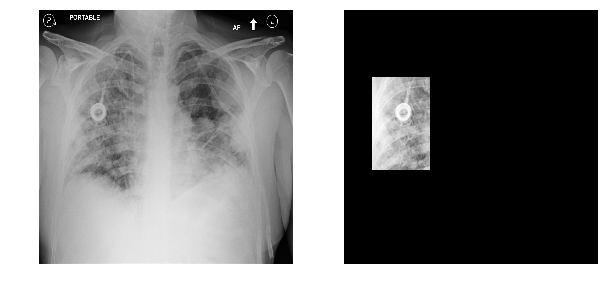

In [20]:
class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

Аугментация.

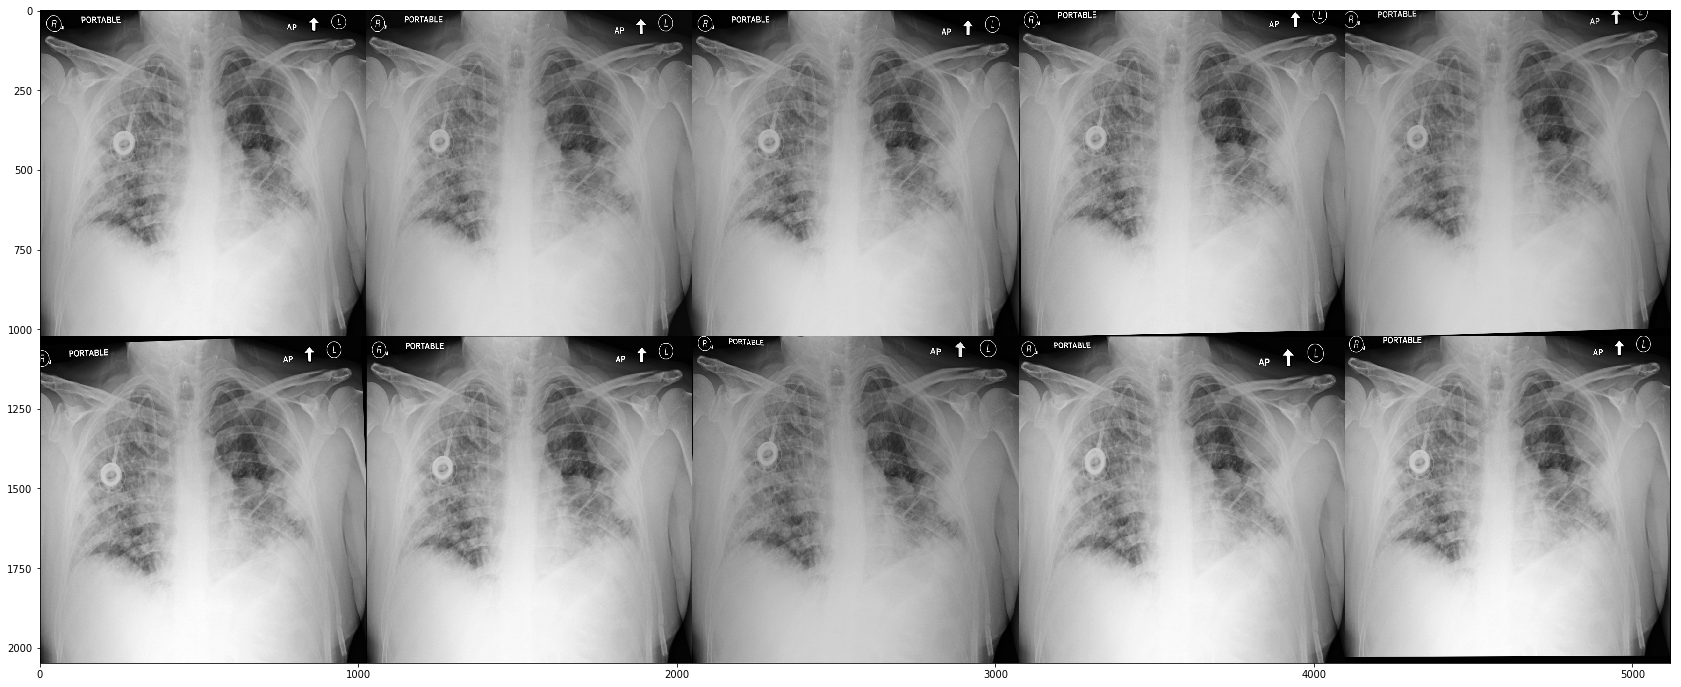

In [21]:
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# Тестируем
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

## Тренируем модель

Примечание: следующая модель предназначена только для демонстрации. Обучение ограничено эпохами и установлено номинальные значения для конфигурации детектора, чтобы сократить время выполнения.

1. dataset_train и dataset_val являются производными от DetectorDataset
1. DetectorDataset загружает изображения из имен файлов изображений и маски из данных аннотации
1. модель mask-rcnn

In [22]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
LEARNING_RATE = 0.005

import warnings 
warnings.filterwarnings("ignore")

In [24]:
%%time

model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None) 


Starting at epoch 0. LR=0.01

Checkpoint Path: /kaggle/working/pneumonia20190330T1436/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4  

In [25]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)


Starting at epoch 2. LR=0.005

Checkpoint Path: /kaggle/working/pneumonia20190330T1436/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

In [26]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=16,
            layers='all',
            augmentation=augmentation)


Starting at epoch 6. LR=0.001

Checkpoint Path: /kaggle/working/pneumonia20190330T1436/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

Выбираем модель

In [27]:
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /kaggle/working/pneumonia20190330T1436/mask_rcnn_pneumonia_0016.h5


Загрузм вновь обученные веса

In [28]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /kaggle/working/pneumonia20190330T1436/mask_rcnn_pneumonia_0016.h5
Re-starting from epoch 16


In [29]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

Как соотносится предсказанные ограничительные рамки с ожидаемыми? Используем выборку отложенную для валидации.

Демонстрация нескольких примеров выборки и их предсказаний

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)


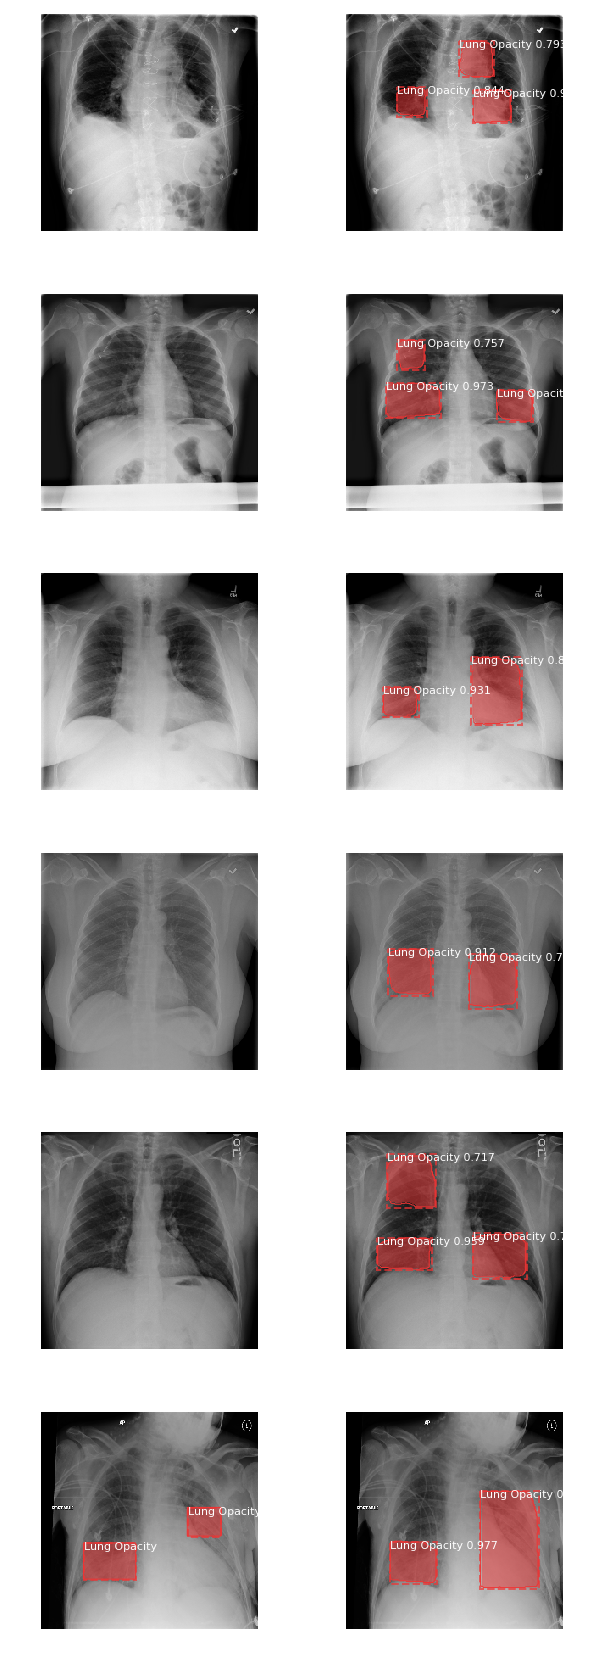

In [30]:
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [31]:
test_image_fps = get_dicom_fps(test_dicom_dir)

Делаем предсказание

In [32]:
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [33]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 1000/1000 [04:39<00:00,  4.05it/s]

/kaggle/working/submission.csv


In [34]:
output = pd.read_csv(submission_fp)
output.head(10)

,patientId,PredictionString
0,2f42fe81-bd2a-4b14-966b-589873d13663,NaN
1,23bf02dd-a965-4b1d-b4f3-060c330f63e9,0.97 332.0 376.0 252.0 376.0
2,2a607bec-696e-4248-b6cc-21a6266744bd,0.98 188.0 500.0 228.0 216.0
3,11e0e617-cc49-478e-bcba-209866654fde,0.99 220.0 120.0 232.0 512.0 0.98 608.0 136.0...
4,1bc755ca-d22a-4a4f-9eb7-acc2e2b45b44,0.95 320.0 220.0 196.0 312.0
5,05ad9fb7-7500-492a-a5db-d8e1c69855e5,0.98 232.0 504.0 172.0 136.0
6,1f6e393f-ae2b-4086-acba-8e4272245a7c,0.97 236.0 592.0 176.0 156.0
7,c1265ac3-6eae-4cf3-9880-26fd430312f3,NaN
8,2b4c09a2-c8d7-4773-84e3-f1aa664fba9a,0.98 220.0 588.0 176.0 148.0 0.96 644.0 276.0...
9,126de93a-1209-428c-aa3d-790991cd14e5,0.98 188.0 632.0 208.0 232.0


Продемонстрируем несколько примеров обнаружении пневмонии

2f6374c9-baec-4236-acb4-a3815dc8243a
[ 42  49 126 106]
x 196 y 168 h 228 w 336
[ 53 144 154 203]
x 576 y 212 h 236 w 404
02cfa7d1-61e0-4d9e-8664-9a7469ccab76
[ 91  58 203 120]
x 232 y 364 h 248 w 448
[ 68 161 208 228]
x 644 y 272 h 268 w 560
05905ac6-1b8f-4793-a7d2-ac794b1bb2ff
[114 156 193 217]
x 624 y 456 h 244 w 316
[113  62 170 116]
x 248 y 452 h 216 w 228
1329b841-9c14-4f7c-9bce-4ba65067a20f
[109  44 154 106]
x 176 y 436 h 248 w 180
[ 97 158 168 222]
x 632 y 388 h 256 w 284


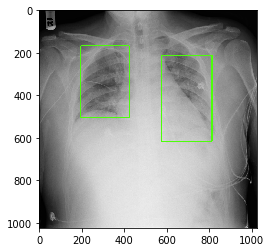

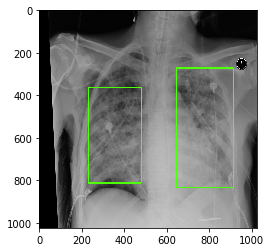

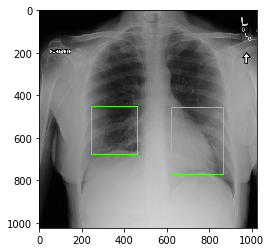

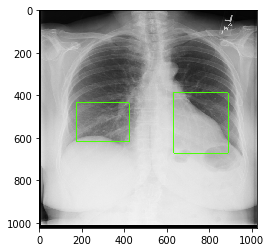

In [35]:
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    
    image = ds.pixel_array
    
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()

In [36]:
!rm -rf /kaggle/working/Mask_RCNN